# Social dimension (Who)
* Misinformation detection exploiting user features
* Detection of malicious users: can we distinguish malicious from gullible users?
* Detection of superspreaders: abnormal rates of misinformation spread
* Detection of sources of misinformation: first users to share misinformation

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import preprocess
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from gensim.models import Word2Vec

%matplotlib inline
sns.set(style="darkgrid")

## Load data users data

In [73]:
# users
df_users = pd.read_csv('data/2018/users.csv')

# credibility score with laplace smoothing

df_users['credibility'] = 1-df_users['misinformation']/(df_users['virals']+1)
df_users = df_users.rename(columns={"misinformation": "misinformations"})
print(df_users.columns)
df_users

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'repeated_messages',
       'repeated_messages_ratio', 'days_active', 'daily_mean', 'daily_std',
       'daily_median', 'daily_95', 'daily_outliers', 'degree_centrality',
       'strenght', 'viral_degree_centrality', 'viral_strenght',
       'misinformations', 'misinformation_degree_centrality',
       'misinformation_strenght', 'misinformation_ratio',
       'viral_misinformation_ratio', 'credibility'],
      dtype='object')


,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,repeated_messages,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,-3818310068976662355,1,4396,3742,0.851228,654,0.148772,24,0.005460,609,...,153,672588,153,3672,10,153,1530,0.002275,0.416667,0.600000
1,5782050016593913959,11,2332,972,0.416810,1360,0.583190,227,0.097341,363,...,1710,498161,1631,48057,58,1506,11907,0.024871,0.255507,0.745614
2,-2072140886659020977,3,2064,948,0.459302,1116,0.540698,243,0.117733,94,...,534,391490,534,46414,85,534,15800,0.041182,0.349794,0.651639
3,2839535797075678550,5,2020,1587,0.785644,433,0.214356,116,0.057426,258,...,895,644390,895,30154,25,866,6179,0.012376,0.215517,0.786325
4,170916900626840870,1,1810,828,0.457459,982,0.542541,111,0.061326,24,...,153,276930,153,16983,69,153,10557,0.038122,0.621622,0.383929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,-3685511676029813622,1,1,0,0.000000,1,1.000000,0,0.000000,0,...,166,166,0,0,0,0,0,0.000000,0.000000,1.000000
5360,-3687281691650946329,1,1,0,0.000000,1,1.000000,0,0.000000,0,...,188,188,0,0,0,0,0,0.000000,0.000000,1.000000
5361,4870300454101875011,1,1,1,1.000000,0,0.000000,0,0.000000,0,...,57,57,0,0,0,0,0,0.000000,0.000000,1.000000
5362,7020988212245908273,1,1,1,1.000000,0,0.000000,0,0.000000,0,...,91,91,0,0,0,0,0,0.000000,0.000000,1.000000


# Associate misinformation with information of the first user that shared

In [74]:

# dataset with labelled data
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')

# select only labelled data
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df = df[df['midia']==0]
df = df[df['misinformation']!=-1]

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)
df = df[['id','text','misinformation', 'timestamp']]

df_full = df.copy()
df.drop_duplicates(subset='text', inplace = True)

df['label'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df['misinformation']]
print(len(df))
df.reset_index(drop=True,inplace=True)
df.head()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


6926


,id,text,misinformation,timestamp,label
0,6942577183305588053,"O dia em que ex-guerrilheiro, militantes e des...",1,2018-07-02 10:46:00,misinformation
1,-2072140886659020977,O nível dos jornalistas do programa Roda Viva ...,1,2018-07-02 10:50:00,misinformation
2,-5100443702615645928,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,2018-07-02 11:03:00,non-misinformation
3,-1561843698204261697,"Gestão do colombiano na capital, imagina ele n...",1,2018-07-02 16:31:00,misinformation
4,-5876784761398352499,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,2018-07-02 18:09:00,misinformation


## Get mean features from all users who shared the message

In [75]:
user_features = df_users.columns[1:]
df_user_features = pd.DataFrame(columns = user_features)

for m in df['text']:
    users = list(set(df_full[df_full['text']==m]['id']))
    df_users_shared = df_users[df_users.apply(lambda x: x['id'] in users, axis = 1)]
    df_users_shared = df_users_shared.mean().to_frame().transpose()[user_features]
    df_user_features = pd.concat([df_user_features, df_users_shared])

df_user_features = df_user_features.reset_index(drop=True)

df = pd.concat([df,df_user_features], axis = 1)

In [76]:
df[user_features]

,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,repeated_messages,repeated_messages_ratio,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,1.0,31.0,4.0,0.129032,27.0,0.870968,1.0,0.032258,0.0,0.000000,...,44.0,1364.0,44.0,44.0,1.0,44.0,44.0,0.032258,1.000000,0.500000
1,2.0,1265.5,548.5,0.389180,717.0,0.610820,142.5,0.103834,47.0,0.049578,...,403.5,259490.5,403.5,28940.0,52.5,403.5,10630.0,0.042004,0.412992,0.593262
2,1.0,340.0,266.0,0.782353,74.0,0.217647,76.0,0.223529,6.0,0.022556,...,270.0,91800.0,270.0,20520.0,47.0,270.0,12690.0,0.138235,0.618421,0.389610
3,6.0,78.0,50.0,0.641026,28.0,0.358974,31.0,0.397436,24.0,0.480000,...,739.0,13472.0,739.0,5505.0,12.0,739.0,1843.0,0.153846,0.387097,0.625000
4,2.0,63.0,35.0,0.555556,28.0,0.444444,12.0,0.190476,17.0,0.485714,...,122.0,3831.0,122.0,724.0,4.0,122.0,244.0,0.063492,0.333333,0.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6921,1.0,36.5,18.0,0.479263,18.5,0.520737,6.5,0.163210,1.0,0.041667,...,207.5,6922.0,207.5,815.5,2.0,44.5,178.0,0.047619,0.181818,0.833333
6922,1.0,42.0,24.0,0.571429,18.0,0.428571,11.0,0.261905,2.0,0.083333,...,89.0,3738.0,89.0,979.0,4.0,89.0,356.0,0.095238,0.363636,0.666667
6923,1.0,17.5,14.5,0.821429,3.0,0.178571,2.0,0.107143,1.5,0.083333,...,306.0,5355.0,306.0,612.0,0.0,0.0,0.0,0.000000,0.000000,1.000000
6924,1.0,327.0,81.0,0.247706,246.0,0.752294,23.0,0.070336,0.0,0.000000,...,95.0,31065.0,95.0,2185.0,12.0,95.0,1140.0,0.036697,0.521739,0.500000


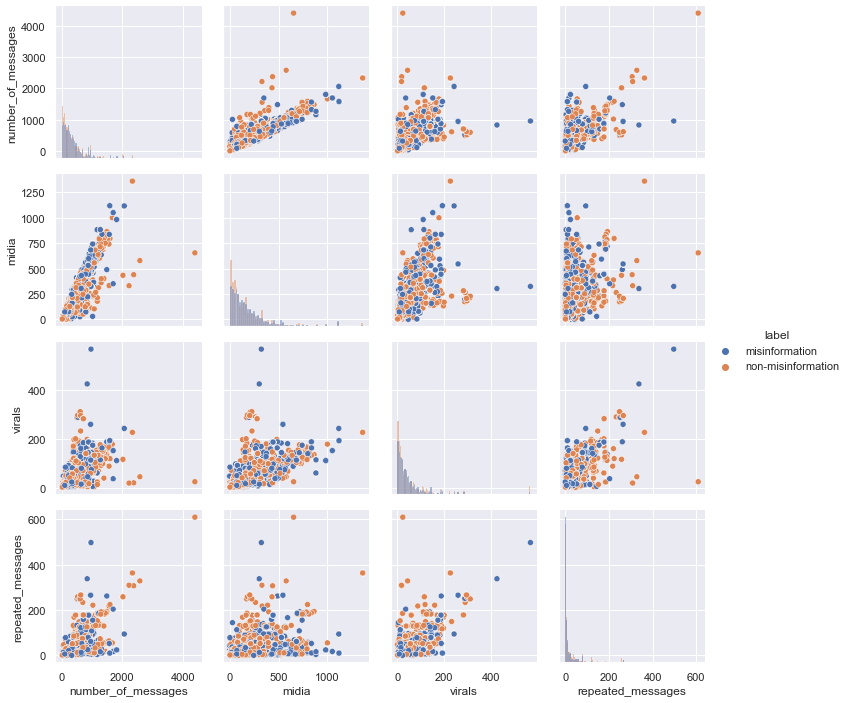

In [77]:
g = sns.PairGrid(df[['number_of_messages', 'midia',
                       'virals', 'repeated_messages','label']], 
                 hue = 'label')

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

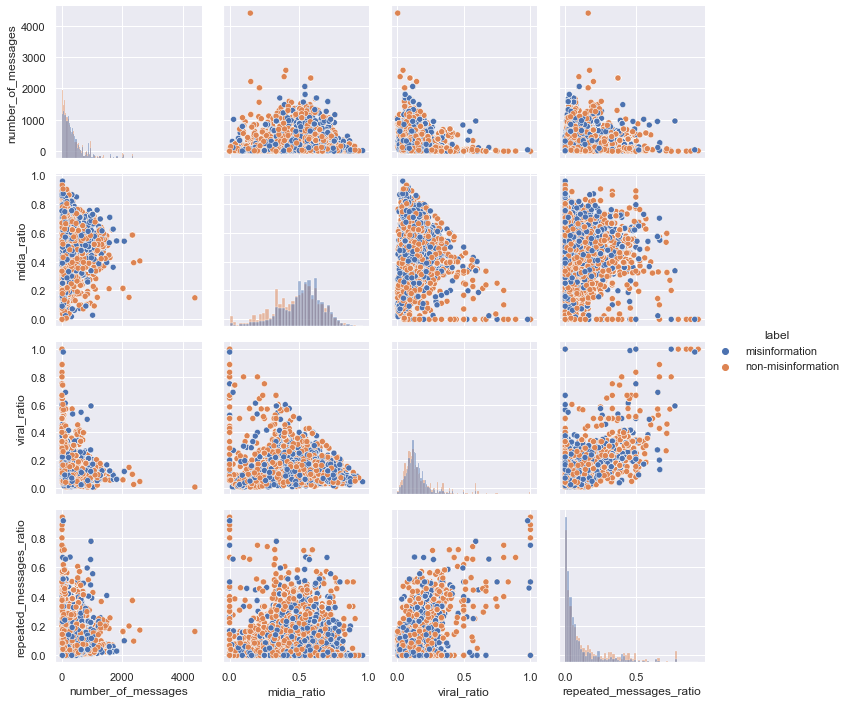

In [78]:
g = sns.PairGrid(df[['number_of_messages', 'midia_ratio',
                       'viral_ratio', 'repeated_messages_ratio','label']], 
                 hue = 'label')

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

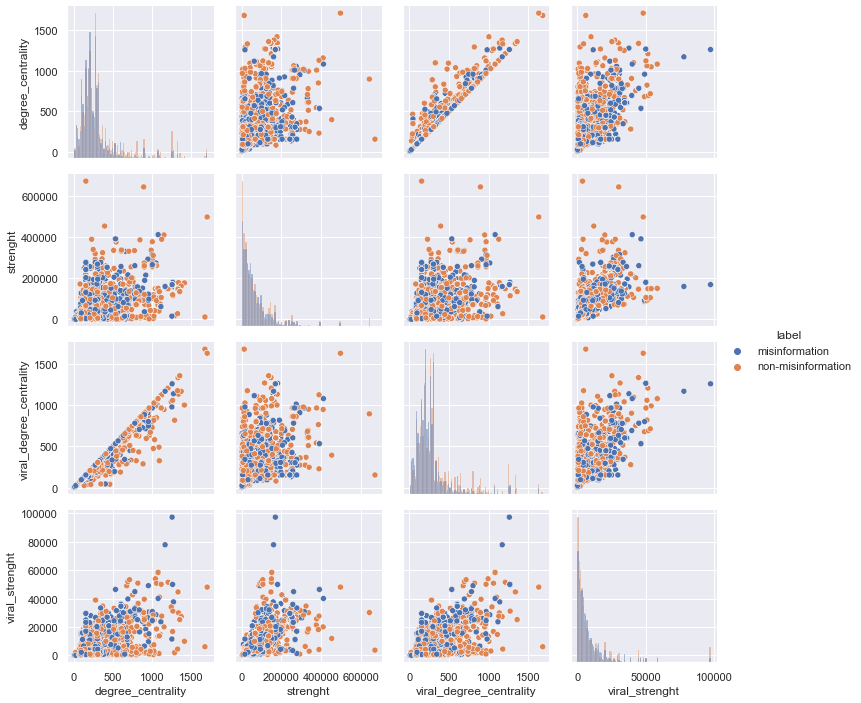

In [79]:
g = sns.PairGrid(df[['degree_centrality', 'strenght',
                     'viral_degree_centrality', 'viral_strenght', 'label']], 
                      hue = 'label', diag_sharey=False)

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

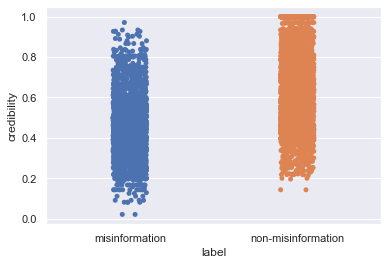

In [80]:
ax = sns.stripplot(x="label", y="credibility", data=df)

From this chart we observe that the credibility is not a good indicator to detect misinformation

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


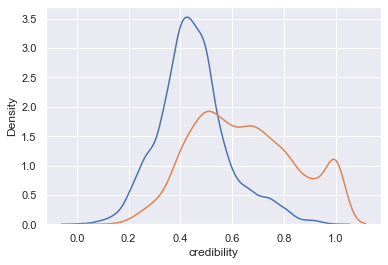

In [81]:
sns.distplot(df[df['label']=='misinformation']['credibility'], hist=False, rug=False)
sns.distplot(df[df['label']=='non-misinformation']['credibility'], hist=False, rug=False)

plt.show()

## Feature engineering

In [82]:
df.columns

Index(['id', 'text', 'misinformation', 'timestamp', 'label', 'groups',
       'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio',
       'virals', 'viral_ratio', 'repeated_messages', 'repeated_messages_ratio',
       'days_active', 'daily_mean', 'daily_std', 'daily_median', 'daily_95',
       'daily_outliers', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformations',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'credibility'],
      dtype='object')

In [83]:
user_features = ['groups', 'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio',
       'virals', 'viral_ratio', 'repeated_messages', 'repeated_messages_ratio',
       'days_active', 'daily_mean', 'daily_median', 'daily_95',
       'daily_outliers', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght']
X = df[user_features]
y = df['misinformation']
X.shape

(6926, 19)

In [84]:
# univariate analysis
X.std()

groups                         1.698039
number_of_messages           392.199143
texts                        219.894628
text_ratio                     0.167764
midia                        209.352306
midia_ratio                    0.167764
virals                        76.265610
viral_ratio                    0.123639
repeated_messages             71.054439
repeated_messages_ratio        0.163807
days_active                   23.642929
daily_mean                     6.626027
daily_median                   6.260392
daily_95                      17.213012
daily_outliers                 1.219270
degree_centrality            281.835386
strenght                   85630.535981
viral_degree_centrality      270.285519
viral_strenght             14172.682647
dtype: float64

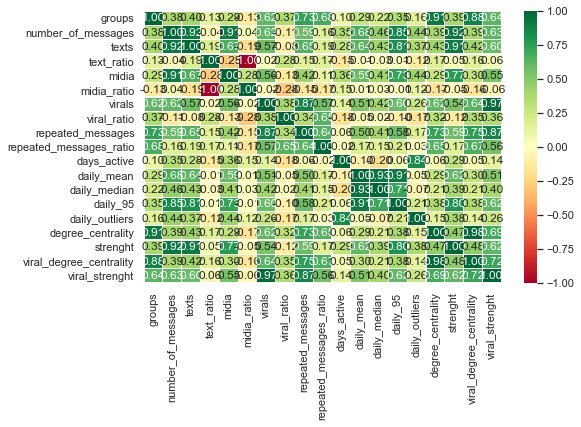

In [85]:
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,5))
#plot heat map
# sns.heatmap(df_similar, annot=True, fmt='.2f', linewidths=.1)
g=sns.heatmap(X[top_corr_features].corr(),annot=True, fmt='.2f', linewidths=.1,cmap="RdYlGn")

[0.02368736 0.03029541 0.04668068 0.06541524 0.05666327 0.04649966
 0.04129336 0.0834962  0.04729328 0.08871146 0.04949341 0.0543953
 0.03236375 0.05727096 0.05233894 0.05008146 0.07014386 0.04791892
 0.05595749]


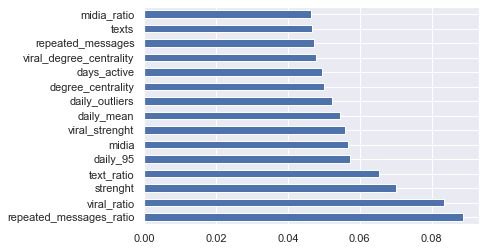

In [86]:
# feature importance

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [87]:
list(feat_importances.nlargest(10).index)

['repeated_messages_ratio',
 'viral_ratio',
 'strenght',
 'text_ratio',
 'daily_95',
 'midia',
 'viral_strenght',
 'daily_mean',
 'daily_outliers',
 'degree_centrality']

In [88]:
user_classification_features = list(feat_importances.nlargest(10).index)

# Exploiting user information to detect misinformation

In [89]:
# messages
df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')

In [90]:
# df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]
# df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]
# df_train.to_csv('data/2018/train-test/train.csv', index = False)
# df_test.to_csv('data/2018/train-test/test.csv', index = False)

In [91]:
# user_classification_features = ['groups', 'number_of_messages', 'midia_ratio',
#        'viral_ratio', , 'degree_centrality', 'strenght',
#        'viral_degree_centrality', 'viral_strenght']

#user_classification_features = ['midia_ratio', 'viral_ratio', 'repeated_messages_ratio']

def acquire_user_info(df_target, df_origin):   

    
    df_user_features = pd.DataFrame(columns = user_classification_features)

    for m in df_target['text']:
        user_info = df_origin[df_origin['text']==m]
        user_info.sort_values(by='timestamp')        
        user_info = user_info[0:1]
        user_info = user_info[user_classification_features] 
        df_user_features = pd.concat([df_user_features, user_info])
        
    df_user_features.reset_index(drop= True, inplace = True)
    df_target = pd.concat([df_target, df_user_features], axis = 1)
    return df_target

df_train = acquire_user_info(df_train, df)
df_test = acquire_user_info(df_test, df)    

In [92]:
df_train.head()

,text,misinformation,original,id_message,preprocessed_text,repeated_messages_ratio,viral_ratio,strenght,text_ratio,daily_95,midia,viral_strenght,daily_mean,daily_outliers,degree_centrality
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0,esquerdo acabar saber que \n stephen kanitz ar...,0.032258,0.177305,8037.0,0.439716,7.000000,79.000000,1425.0,1.205128,2.000000,57.000000
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0,ler artigo \n \n \n esquerdo acabar saber que ...,0.412993,0.397472,150659.0,0.605337,29.300000,281.000000,58364.0,9.128205,4.000000,1080.000000
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0,esquerdo acabar saber que ? \n stephen kanitz ...,0.030769,0.142268,44135.0,0.268041,38.600000,355.000000,6279.0,13.857143,2.000000,91.000000
3,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.040866,0.141648,41312.0,0.331785,9.333333,142.666667,3213.0,2.922734,2.666667,142.666667
4,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.025641,0.190244,30340.0,0.380488,11.300000,127.000000,5772.0,1.737288,6.000000,148.000000


In [93]:
# include viral strenght
# X_train = df_train[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# X_test = df_test[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# y_train = df_train['misinformation']
# y_test = df_test['misinformation']
# X_train,X_test = utils.z_score(X_train,X_test)
# X_train.shape


X_train = df_train[user_classification_features].to_numpy()
X_train = np.array(X_train, dtype=np.float64)
X_test = df_test[user_classification_features].to_numpy()
X_test = np.array(X_test, dtype=np.float64)
y_train = df_train['misinformation']
y_test = df_test['misinformation']

X_train_u, X_test_u = utils.z_score(X_train, X_test)
X_train, X_test = utils.z_score(X_train, X_test)

print('train', X_train.shape)
print('test', X_test.shape)

# with open('train_user_features.npy', 'wb') as f:
#     np.save(f, X_train)
    
# with open('test_user_features.npy', 'wb') as f:
#     np.save(f, X_test)

train (6233, 10)
test (1574, 10)


logistic regression + user info
0.49
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       834
           1       0.57      0.64      0.60       740

    accuracy                           0.60      1574
   macro avg       0.60      0.60      0.60      1574
weighted avg       0.61      0.60      0.60      1574

AUC:  0.6192867327759414


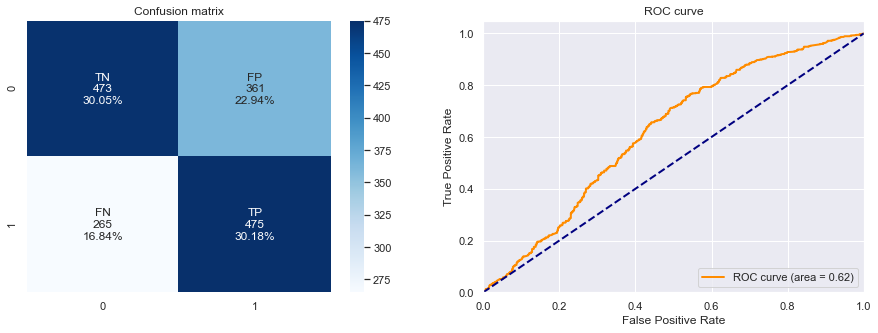

0,602
0,398
0,568
0,641
0,602
0,619


(0.602287166454892,
 0.3982188295165393,
 0.5681818181818182,
 0.6418918918918919,
 0.6027918781725888,
 0.6192867327759414)

In [94]:
print('logistic regression + user info')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.580
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.571
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.556
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.582
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.599

--------------------
BEST PARAMETERS (validation AUC = 0.599)
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
--------------------
0.48
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       834
           1       0.56      0.72      0.63       740

    accuracy                           0.60      1574
   macro avg       0.61      0.61      0.60      1574
weighted avg       0.62      0.60      0.60      1574

AUC:  0.6358966880549615


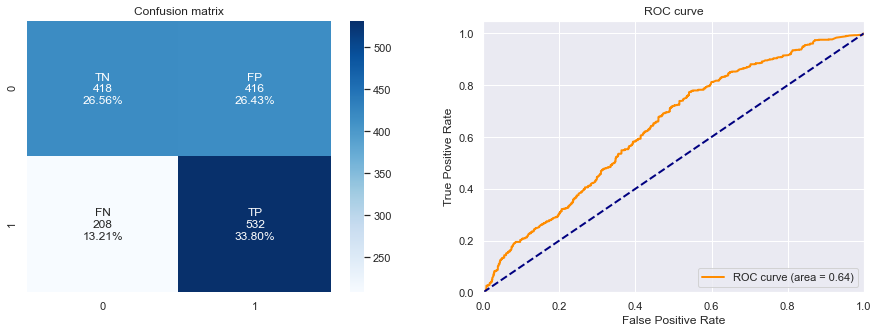

0,603
0,427
0,561
0,718
0,630
0,635


(0.6035578144853876,
 0.4273972602739726,
 0.5611814345991561,
 0.7189189189189189,
 0.6303317535545024,
 0.6358966880549615)

In [95]:
print('mlp + user')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Combining with text

## User + Word2Vec

In [96]:
w2v = Word2Vec.load("data/2018/word2vec.model")
X_train_w = utils.vectorize_corpus(w2v, df_train['preprocessed_text'])
X_test_w = utils.vectorize_corpus(w2v, df_test['preprocessed_text'])

In [97]:
X_train = np.concatenate((X_train_w, X_train_u), axis=1)
X_test = np.concatenate((X_test_w, X_test_u), axis=1)

logistic regression + user info + w2v
0.47
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       834
           1       0.70      0.77      0.73       740

    accuracy                           0.74      1574
   macro avg       0.74      0.74      0.74      1574
weighted avg       0.74      0.74      0.74      1574

AUC:  0.8087610992287251


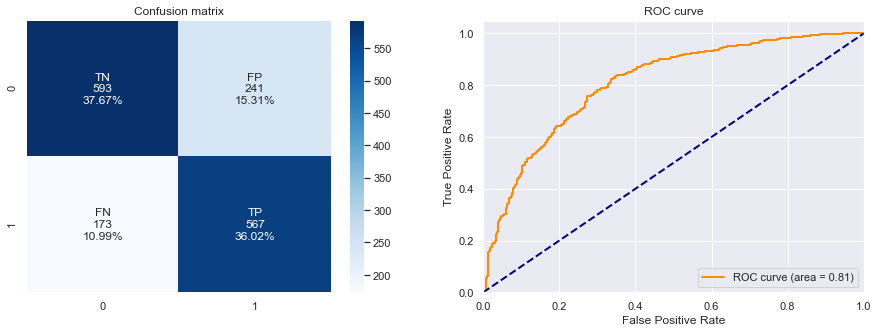

0,736
0,258
0,701
0,766
0,732
0,808


(0.7369758576874206,
 0.2587499999999999,
 0.7017326732673267,
 0.7662162162162162,
 0.7325581395348837,
 0.8087610992287251)

In [98]:
print('logistic regression + user info + w2v')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.776
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.756
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.814
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.769
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.792
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.774
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.798
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.780
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.798
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.798

--------------------
BEST PARAMETERS (validation AUC = 0.814)
h

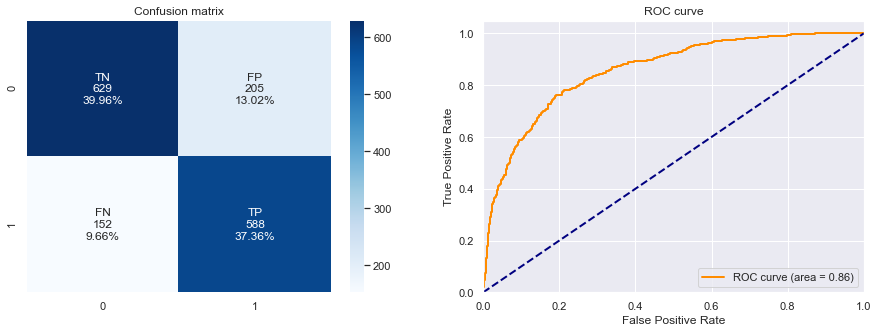

0,773
0,221
0,741
0,794
0,767
0,856


(0.7731893265565438,
 0.22105263157894728,
 0.7414880201765448,
 0.7945945945945946,
 0.767123287671233,
 0.8569349925465033)

In [99]:
print('mlp + user + w2v')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

## TF-IDF + users

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
tfidf = TfidfVectorizer(max_features = None, ngram_range = (1,1), #(1,3)  #15000
                             lowercase = False, token_pattern = r'[^\s]+', binary=False)

tfidf.fit(df_train['preprocessed_text'])   
X_train_tfidf = tfidf.transform(df_train['preprocessed_text']).todense()
X_test_tfidf = tfidf.transform(df_test['preprocessed_text']).todense()
X_train_tfidf.shape

(6233, 17525)

In [101]:
X_train = np.concatenate((X_train_tfidf, X_train_u), axis=1)
X_test = np.concatenate((X_test_tfidf, X_test_u), axis=1)

logistic regression + user info + tfidf
0.48
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       834
           1       0.79      0.78      0.78       740

    accuracy                           0.80      1574
   macro avg       0.80      0.79      0.80      1574
weighted avg       0.80      0.80      0.80      1574

AUC:  0.8659132153736471


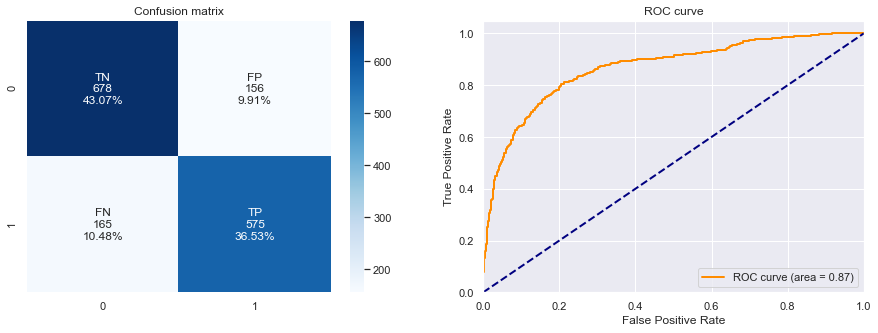

0,796
0,191
0,786
0,777
0,781
0,865


(0.7960609911054638,
 0.19141323792486586,
 0.786593707250342,
 0.777027027027027,
 0.7817811012916384,
 0.8659132153736471)

In [102]:
print('logistic regression + user info + tfidf')
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + tfidf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.833
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.867
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.869
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.877
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.865
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.846
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.869
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.872
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.877
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.869

--------------------
BEST PARAMETERS (validation AUC = 0.877)

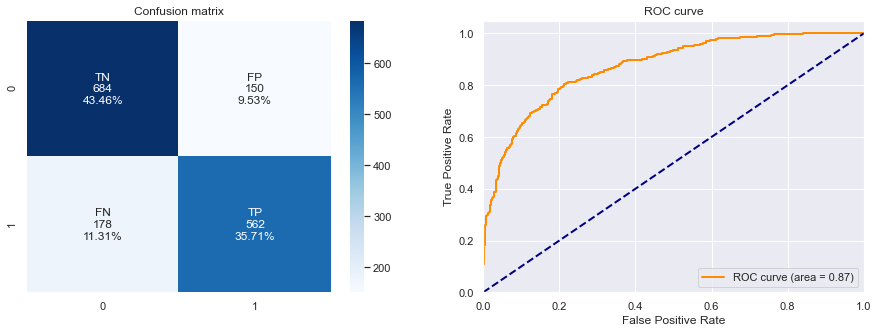

0,791
0,193
0,789
0,759
0,774
0,872


(0.7916137229987293,
 0.19339622641509435,
 0.7893258426966292,
 0.7594594594594595,
 0.7741046831955922,
 0.8723572493356665)

In [103]:
print('mlp + user + tfidf')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)